# Implementacia SVM RBF

In [16]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score



from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer, fbeta_score, f1_score
from imblearn.metrics import specificity_score


from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score



pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

In [2]:
RATIOS = ['L1',
       'L2', 'L3', 'NCL_CF', 'CASH_TA', 'INV_COGS', 'CC_SAL', 'TL_COST',
       'CL_COST', 'SAL_TA', 'EQ_TA', 'EQ_TL', 'CL_CC', 'LTC_NCA', 'TZ',
       'CF_TL', 'CL_TA', 'NCL_TA', 'EBT_REV', 'ROS', 'EAT_REV', 'ROA', 'ROE',
       'CF_TA', 'CF_SAL', 'LABOR_EAT', 'LABOR_REV']

PRIMARY_VALUES = [
    'CA', 'CASH',
       'CL', 'EQ', 'NCL', 'TA', 'TL', 'CC', 'INV', 'CF_NETTO', 'CF_SELFFIN',
       'REV', 'VA', 'OE', 'EAT', 'EBIT', 'SAL', 'COST', 'INT'
]


REDUCED_FEATURE_SET = ['L1', 'L3', 'EQ_TA', 'CL_CC', 'LTC_NCA', 'TZ', 'CF_TL', 'CL_TA', 'ROS', 'ROA', 'ROE']

SKNACE_ONE_HOT = ['sknace_C', 'sknace_F', 'sknace_G', 'sknace_H', 'sknace_M', 'sknace_other']

FINAL_FEATURE_SET = ['L3', 'EQ_TA', 'LTC_NCA', 'TZ', 'CF_TL', 'CL_TA', 'ROS', 'ROA', 'ROE']

In [4]:
training_raw = pd.read_csv('../../../DATA/FINAL/final/training_sample.csv')
testing_raw = pd.read_csv('../../../DATA/FINAL/final/testing_sample.csv')
training_raw.shape, testing_raw.shape

((7188, 107), (1797, 107))

In [5]:
SAL_CLASSES = training_raw['sal_class'].unique()
SKNACE_GROUPS = training_raw['sknace_division_normalized'].unique()

In [6]:
training_filled = training_raw.copy()
testing_filled = testing_raw.copy()

In [10]:

from sklearn.feature_selection import RFECV
from sklearn.metrics import f1_score
from imblearn.metrics import specificity_score



def eval(real, pred, label):
    print(f'real_positives = {sum(real)}, total = {len(real)}')
    recall = recall_score(real, pred)
    accuracy = accuracy_score(real, pred)
    print(f"{label} Accuracy:", accuracy)
    print(f"{label} Precision:", precision_score(real, pred))
    print(f"{label} Recall:", recall)
    print(f"{label} Specificity:", specificity_score(real, pred))
    print(f"{label} F1 Score:", f1_score(real, pred))

    cm = confusion_matrix(real, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(label)
    plt.show()

## Priprava dat

In [12]:
FINAL_FEATURE_SET = ['L3', 'EQ_TA', 'LTC_NCA', 'TZ', 'CF_TL', 'CL_TA', 'ROS', 'ROA', 'ROE']

In [14]:

Q = training_filled.query('combined_issue_criteria_3y_off == 1')['entity_id'].nunique()

control_group_ratio = 1.5

training_balanced = (
    pd.concat(
        [
            training_filled.query('combined_issue_criteria_3y_off == 0').sample(int(Q * control_group_ratio)),
            training_filled.query('combined_issue_criteria_3y_off == 1').sample(Q),
        ], axis = 0
    )
)



Q_test = testing_filled.query('combined_issue_criteria_3y_off == 1')['entity_id'].nunique()

testing_balanced = (
    pd.concat(
        [
            testing_filled.query('combined_issue_criteria_3y_off == 0').sample(int(Q_test * control_group_ratio)),
            testing_filled.query('combined_issue_criteria_3y_off == 1').sample(Q_test),
        ], axis = 0
    )
)


X_train_balanced = training_balanced[FINAL_FEATURE_SET].values
y_train_balanced = training_balanced['combined_issue_criteria_3y_off'].values

X_test_balanced = testing_balanced[FINAL_FEATURE_SET].values
y_test_balanced = testing_balanced['combined_issue_criteria_3y_off'].values

X_train_imbalanced = training_filled[FINAL_FEATURE_SET].values
y_train_imbalanced = training_filled['combined_issue_criteria_3y_off'].values

X_test_imbalanced = testing_filled[FINAL_FEATURE_SET].values
y_test_imbalanced = testing_filled['combined_issue_criteria_3y_off'].values


X_train_valid_imbalanced, X_valid_valid_imbalanced, y_train_valid_imbalanced, y_valid_valid_imbalanced = train_test_split(
    X_train_imbalanced, y_train_imbalanced, test_size=0.2, random_state=42)


from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

counter = Counter(y_train_valid_imbalanced)
print(f"Original class distribution: {counter}")

minority_class_count = counter[1]
desired_majority_class_count = (minority_class_count * 3) // 2

sampling_strategy = {0: desired_majority_class_count, 1: minority_class_count}

rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_train_valid_balanced, y_train_valid_balanced = rus.fit_resample(X_train_valid_imbalanced, y_train_valid_imbalanced)



Original class distribution: Counter({0.0: 5183, 1.0: 567})


In [17]:
# print('\nTEST')
# print(pd.Series(y_test_balanced).value_counts())
# print(pd.Series(y_test_imbalanced).value_counts())

# print('\nTRAIN')
# print(pd.Series(y_train_balanced).value_counts())
# print(pd.Series(y_train_imbalanced).value_counts())

# print('\nTRAIN W VALID')
# print(pd.Series(y_train_valid_balanced).value_counts())
# print(pd.Series(y_train_valid_imbalanced).value_counts())

# print('\nVALID')
# print(pd.Series(y_valid_valid_imbalanced).value_counts())

## Hyper param optimization

In [18]:

# # first generation
# param_grid = {
#     'C': [0.01, 0.1, 1, 10, 100, 1000, 10000],
#     'gamma': [1e-0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
# }


# second generation
param_grid = {
    'C': [100, 1000, 10000],
    'gamma': [1e-2, 1e-3, 1e-4]
}




# Create an XGBoost classifier
svm_classifier = SVC(kernel='rbf', random_state=37)

grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=5, n_jobs=4, verbose=10, scoring='f1')
grid_search.fit(X_train_balanced, y_train_balanced)

grid_search.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=SVC(random_state=37), n_jobs=4,
             param_grid={'C': [100, 1000, 10000],
                         'gamma': [0.01, 0.001, 0.0001]},
             scoring='f1', verbose=10)

In [19]:
cv_results = pd.DataFrame(grid_search.cv_results_)

# print(cv_results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']])

sorted_cv_results = cv_results.sort_values(by='rank_test_score')
sorted_cv_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,0.475354,0.066430,0.091951,0.044190,10000,0.0001,"{'C': 10000, 'gamma': 0.0001}",0.633745,0.593156,0.672131,0.577406,0.591440,0.613575,0.034787,1
4,0.293470,0.042471,0.070820,0.010970,1000,0.001,"{'C': 1000, 'gamma': 0.001}",0.616667,0.583658,0.674897,0.585774,0.596078,0.611415,0.033825,2
7,2.124343,0.583821,0.058095,0.010536,10000,0.001,"{'C': 10000, 'gamma': 0.001}",0.585774,0.578125,0.663968,0.588235,0.578125,0.598845,0.032812,3
5,0.180151,0.011890,0.068235,0.011722,1000,0.0001,"{'C': 1000, 'gamma': 0.0001}",0.616034,0.568093,0.638655,0.576271,0.591440,0.598099,0.026029,4
6,6.824602,1.553388,0.055769,0.021812,10000,0.01,"{'C': 10000, 'gamma': 0.01}",0.611765,0.588679,0.620690,0.588710,0.561798,0.594328,0.020594,5
1,0.133741,0.015990,0.063659,0.014872,100,0.001,"{'C': 100, 'gamma': 0.001}",0.595745,0.595420,0.623932,0.570213,0.548387,0.586739,0.025627,6
0,0.187940,0.018097,0.062403,0.009465,100,0.01,"{'C': 100, 'gamma': 0.01}",0.614108,0.570312,0.661417,0.545455,0.532258,0.584710,0.047429,7
3,0.675661,0.078590,0.053663,0.009372,1000,0.01,"{'C': 1000, 'gamma': 0.01}",0.581967,0.580153,0.625483,0.569038,0.528000,0.576928,0.031143,8
2,0.133917,0.010050,0.079925,0.011728,100,0.0001,"{'C': 100, 'gamma': 0.0001}",0.487805,0.506438,0.523810,0.490000,0.495413,0.500693,0.013234,9


In [20]:
head = cv_results.sort_values(by='rank_test_score').head(8)


new_params = dict()

for param_name in cv_results.columns:
    if 'param_' in param_name:
        new_params[param_name] = list(head[param_name].unique())

display(new_params)      


{'param_C': [10000, 1000, 100], 'param_gamma': [0.0001, 0.001, 0.01]}

## VALIDATION

In [24]:
pd.Series(y_valid_valid_imbalanced).value_counts()

0.0    1305
1.0     133
dtype: int64

In [25]:
def predict_w_threshold(estimator, X, threshold):
    proba = estimator.predict_proba(X)[:, 1]
    return (proba >= threshold).astype(int)

real_positives = 133.0, total = 1438
SEMIFINAL MODEL IMBALANCED Accuracy: 0.8226703755215578
SEMIFINAL MODEL IMBALANCED Precision: 0.2852112676056338
SEMIFINAL MODEL IMBALANCED Recall: 0.6090225563909775
SEMIFINAL MODEL IMBALANCED Specificity: 0.8444444444444444
SEMIFINAL MODEL IMBALANCED F1 Score: 0.3884892086330936


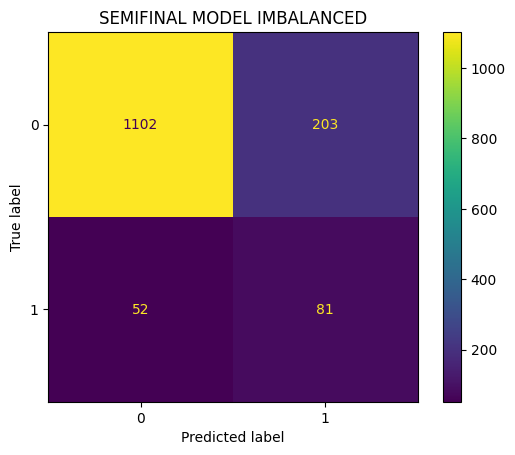

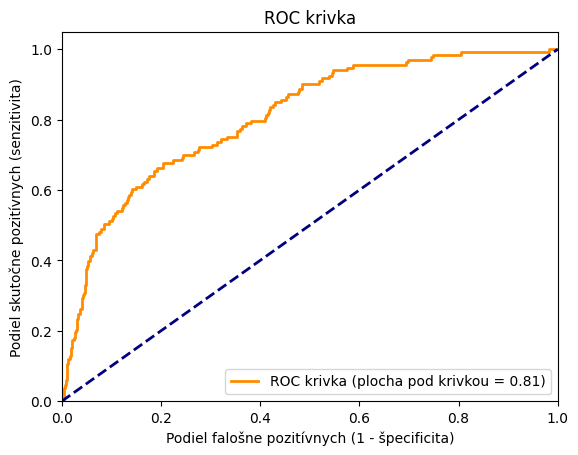

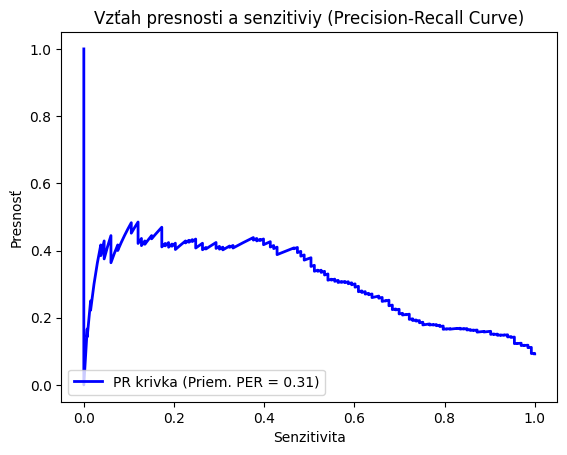

Threshold for 70% recall: 0.028087630840129604
Actual recall: 1.00
real_positives = 133.0, total = 1438
FINAL MODEL IMBALANCED Accuracy: 0.7357440890125174
FINAL MODEL IMBALANCED Precision: 0.21478060046189376
FINAL MODEL IMBALANCED Recall: 0.6992481203007519
FINAL MODEL IMBALANCED Specificity: 0.7394636015325671
FINAL MODEL IMBALANCED F1 Score: 0.3286219081272085


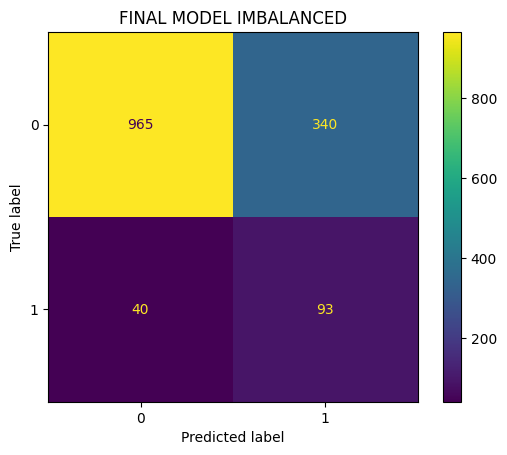

In [26]:

svm_classifier = SVC(kernel='rbf', random_state=13, C = 10000, gamma=0.0001, probability=True)


svm_classifier.fit(X_train_valid_balanced, y_train_valid_balanced)

eval(y_valid_valid_imbalanced, svm_classifier.predict(X_valid_valid_imbalanced), 'SEMIFINAL MODEL IMBALANCED')


y_probs = svm_classifier.predict_proba(X_valid_valid_imbalanced)[:, 1]

fpr, tpr, thresholds = roc_curve(y_valid_valid_imbalanced, y_probs)

roc_auc = roc_auc_score(y_valid_valid_imbalanced, y_probs)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC krivka (plocha pod krivkou = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Podiel falošne pozitívnych (1 - špecificita)')
plt.ylabel('Podiel skutočne pozitívnych (senzitivita)')
plt.title('ROC krivka')
plt.legend(loc='lower right')
plt.show()

precision, recall, thresholds = precision_recall_curve(y_valid_valid_imbalanced, y_probs)

average_precision = average_precision_score(y_valid_valid_imbalanced, y_probs)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PR krivka (Priem. PER = {average_precision:.2f})')
plt.xlabel('Senzitivita')
plt.ylabel('Presnosť')
plt.title('Vzťah presnosti a senzitiviy (Precision-Recall Curve)')
plt.legend(loc='lower left')
plt.show()



target_recall = 0.70
threshold = thresholds[np.argmax(recall >= target_recall)]

y_pred = (y_probs >= threshold).astype(int)

actual_recall = recall_score(y_valid_valid_imbalanced, y_pred)


print(f"Threshold for 70% recall: {threshold}")
print(f"Actual recall: {actual_recall:.2f}")




eval(y_valid_valid_imbalanced, predict_w_threshold(svm_classifier, X_valid_valid_imbalanced, 0.4), 'FINAL MODEL IMBALANCED')

## FINAL TESTING

real_positives = 700.0, total = 1750
FINAL MODEL TRAIN BALANCED Accuracy: 0.7485714285714286
FINAL MODEL TRAIN BALANCED Precision: 0.7329749103942652
FINAL MODEL TRAIN BALANCED Recall: 0.5842857142857143
FINAL MODEL TRAIN BALANCED Specificity: 0.8580952380952381
FINAL MODEL TRAIN BALANCED F1 Score: 0.6502384737678856


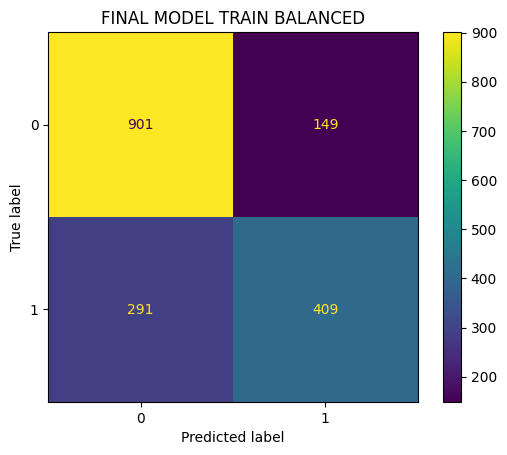

real_positives = 172.0, total = 430
FINAL MODEL BALANCED Accuracy: 0.7069767441860465
FINAL MODEL BALANCED Precision: 0.6642857142857143
FINAL MODEL BALANCED Recall: 0.5406976744186046
FINAL MODEL BALANCED Specificity: 0.8178294573643411
FINAL MODEL BALANCED F1 Score: 0.5961538461538461


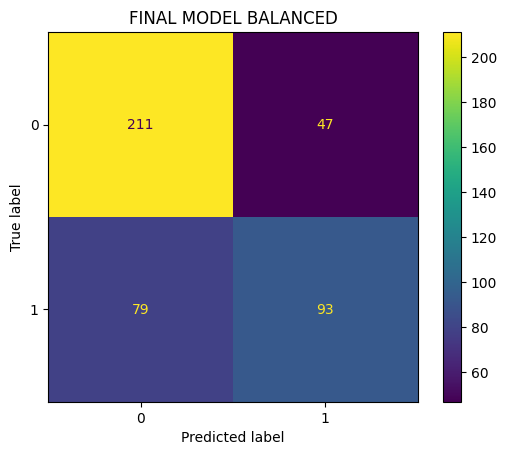

real_positives = 172.0, total = 1797
FINAL MODEL IMBALANCED Accuracy: 0.8152476349471341
FINAL MODEL IMBALANCED Precision: 0.26878612716763006
FINAL MODEL IMBALANCED Recall: 0.5406976744186046
FINAL MODEL IMBALANCED Specificity: 0.8443076923076923
FINAL MODEL IMBALANCED F1 Score: 0.3590733590733591


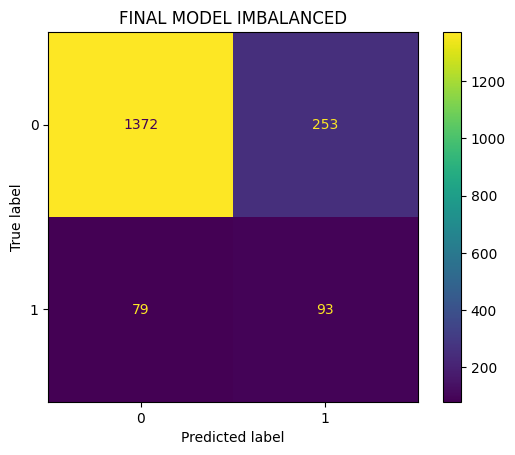

real_positives = 172.0, total = 430
FINAL MODEL BALANCED Accuracy: 0.713953488372093
FINAL MODEL BALANCED Precision: 0.6243654822335025
FINAL MODEL BALANCED Recall: 0.7151162790697675
FINAL MODEL BALANCED Specificity: 0.7131782945736435
FINAL MODEL BALANCED F1 Score: 0.6666666666666667


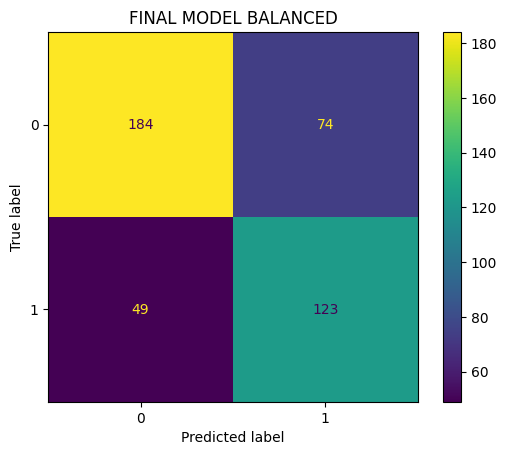

real_positives = 172.0, total = 1797
FINAL MODEL IMBALANCED Accuracy: 0.7217584863661658
FINAL MODEL IMBALANCED Precision: 0.21428571428571427
FINAL MODEL IMBALANCED Recall: 0.7151162790697675
FINAL MODEL IMBALANCED Specificity: 0.7224615384615385
FINAL MODEL IMBALANCED F1 Score: 0.32975871313672916


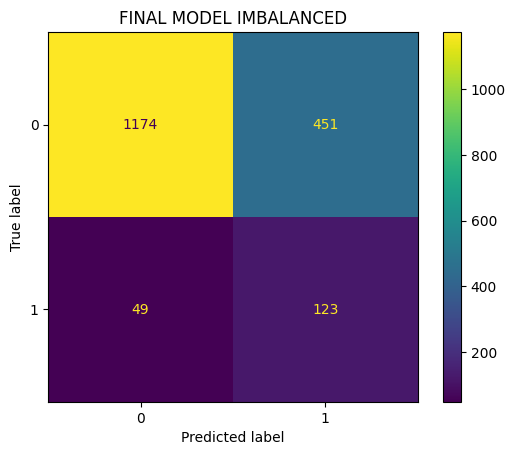

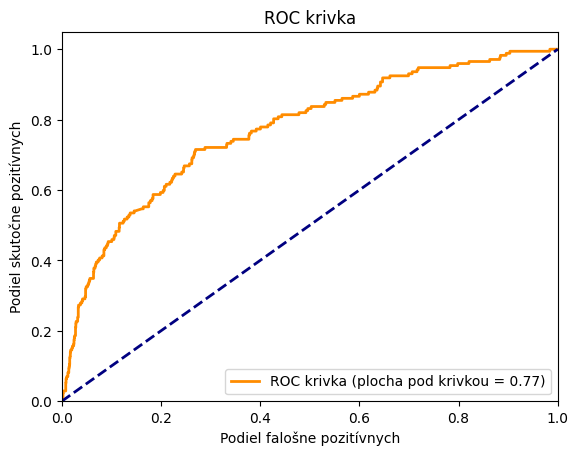

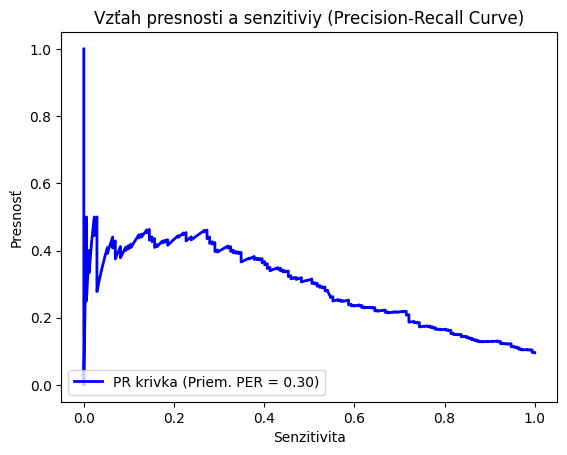

In [27]:
rf_final = SVC(kernel='rbf', random_state=13, C = 10000, gamma=0.0001, probability=True)

rf_final.fit(X_train_balanced, y_train_balanced)


eval(y_train_balanced, rf_final.predict(X_train_balanced), 'FINAL MODEL TRAIN BALANCED')
eval(y_test_balanced, rf_final.predict(X_test_balanced), 'FINAL MODEL BALANCED')
eval(y_test_imbalanced, rf_final.predict(X_test_imbalanced), 'FINAL MODEL IMBALANCED')


eval(y_test_balanced,predict_w_threshold(rf_final, X_test_balanced, 0.4), 'FINAL MODEL BALANCED')
eval(y_test_imbalanced, predict_w_threshold(rf_final, X_test_imbalanced, 0.4), 'FINAL MODEL IMBALANCED')



y_probs = rf_final.predict_proba(X_test_imbalanced)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_imbalanced, y_probs)

roc_auc = roc_auc_score(y_test_imbalanced, y_probs)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC krivka (plocha pod krivkou = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Podiel falošne pozitívnych')
plt.ylabel('Podiel skutočne pozitívnych')
plt.title('ROC krivka')
plt.legend(loc='lower right')
plt.show()

precision, recall, thresholds = precision_recall_curve(y_test_imbalanced, y_probs)

average_precision = average_precision_score(y_test_imbalanced, y_probs)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PR krivka (Priem. PER = {average_precision:.2f})')
plt.xlabel('Senzitivita')
plt.ylabel('Presnosť')
plt.title('Vzťah presnosti a senzitiviy (Precision-Recall Curve)')
plt.legend(loc='lower left')
plt.show()

